In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from scipy import stats
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential
import seaborn as sns
import joblib
from custom_transformers import outlier_clipper

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
dataset = pd.read_csv('realistic_subject_difficulty_dataset.csv')

print(dataset.shape)

dataset.head()

(30000, 12)


,Student_ID,Subject,Difficulty_Level,Midterm_Score,Final_Score,Quiz_Avg,Assignment_Completion_%,Attendance_%,Help_Seeking_Freq,Classroom_Behavior_Score,Submission_Punctuality,Performance
0,1,AI,4,49.729545,52.182194,64.336185,64.370788,93.816161,4,2.775840,On Time,Good
1,2,AI,4,43.083216,49.562362,62.047431,23.572177,86.346815,4,3.918936,On Time,Average
2,3,AI,4,37.520454,54.503075,66.752802,27.787054,91.032778,5,4.983896,On Time,Average
3,4,AI,4,60.929397,70.334479,78.190041,93.944225,93.587055,5,3.612891,On Time,Good
4,5,AI,4,53.986757,63.630252,55.851495,6.900314,81.546249,1,3.261090,On Time,Good


In [7]:
dataset['Performance'].value_counts()

Performance
Good         16576
Average      11594
Excellent     1547
Fail           283
Name: count, dtype: int64

0 => Average, 1 => Excellent, 2 => Fail, 3 => Good

In [8]:
result_dict = {0:'Average', 1:'Excellent', 2:'Fail', 3:'Good'}

In [9]:
dataset['Performance'].value_counts()

Performance
Good         16576
Average      11594
Excellent     1547
Fail           283
Name: count, dtype: int64

In [10]:
le = LabelEncoder()
dataset['Performance'] = le.fit_transform(dataset['Performance'])

In [11]:
dataset['Performance'].value_counts()

Performance
3    16576
0    11594
1     1547
2      283
Name: count, dtype: int64

# EDA 

In [12]:
dataset.isnull().sum()

Student_ID                  0
Subject                     0
Difficulty_Level            0
Midterm_Score               0
Final_Score                 0
Quiz_Avg                    0
Assignment_Completion_%     0
Attendance_%                0
Help_Seeking_Freq           0
Classroom_Behavior_Score    0
Submission_Punctuality      0
Performance                 0
dtype: int64

In [13]:
dataset['Performance'].value_counts()

Performance
3    16576
0    11594
1     1547
2      283
Name: count, dtype: int64

In [14]:
max_mid_score = {}
max_end_score = {}
max_quiz_score = {}

min_mid_score = {}
min_end_score = {}
min_quiz_score = {}

for subject in dataset['Subject'].unique():
    subject_data = dataset[dataset['Subject'] == subject]
    
    max_mid_score[subject] = subject_data['Midterm_Score'].max()
    max_end_score[subject] = subject_data['Final_Score'].max()
    max_quiz_score[subject] = subject_data['Quiz_Avg'].max()

    min_mid_score[subject] = subject_data['Midterm_Score'].min()
    min_end_score[subject] = subject_data['Final_Score'].min()
    min_quiz_score[subject] = subject_data['Quiz_Avg'].min()
    
for subject in dataset['Subject'].unique():
    print(f"Subject : {subject}")
    print(f"Max Mid-Term Score : {max_mid_score[subject]}\nMax End-Term Score : {max_end_score[subject]}\nMax Quiz Score Avg : {max_quiz_score[subject]}")
    print(f"Min Mid-Term Score : {min_mid_score[subject]}\nMin End-Term Score : {min_end_score[subject]}\nMin Quiz Score Avg : {min_quiz_score[subject]}\n")

Subject : AI
Max Mid-Term Score : 84.0
Max End-Term Score : 84.0
Max Quiz Score Avg : 84.0
Min Mid-Term Score : 24.0
Min End-Term Score : 24.0
Min Quiz Score Avg : 26.530509781825376

Subject : DBMS
Max Mid-Term Score : 88.0
Max End-Term Score : 88.0
Max Quiz Score Avg : 88.0
Min Mid-Term Score : 28.0
Min End-Term Score : 28.0
Min Quiz Score Avg : 34.226918775531814

Subject : OS
Max Mid-Term Score : 84.0
Max End-Term Score : 84.0
Max Quiz Score Avg : 84.0
Min Mid-Term Score : 24.0
Min End-Term Score : 24.0
Min Quiz Score Avg : 33.20605849031015

Subject : Data Structures
Max Mid-Term Score : 84.0
Max End-Term Score : 84.0
Max Quiz Score Avg : 84.0
Min Mid-Term Score : 24.0
Min End-Term Score : 24.0
Min Quiz Score Avg : 33.191143322540256

Subject : English
Max Mid-Term Score : 96.0
Max End-Term Score : 96.0
Max Quiz Score Avg : 96.0
Min Mid-Term Score : 36.0
Min End-Term Score : 36.0
Min Quiz Score Avg : 36.15345567966331

Subject : Java
Max Mid-Term Score : 88.0
Max End-Term Score : 

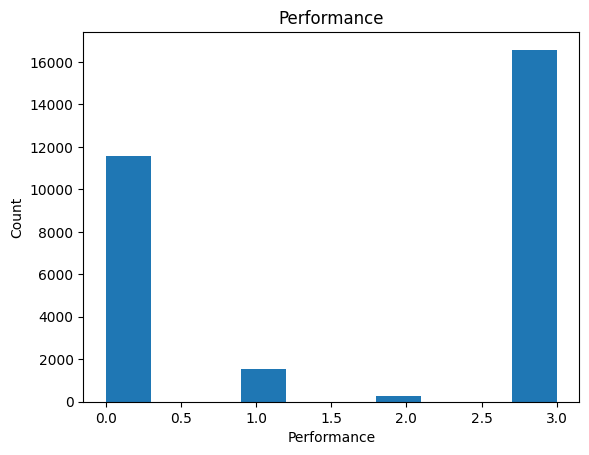

In [15]:
plt.hist(dataset['Performance'])
plt.title('Performance')
plt.xlabel('Performance')
plt.ylabel('Count')
plt.show()

In [16]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtype != 'O' and feature != 'Performance' and feature != 'Student_ID']
categorical_features = [feature for feature in dataset.columns if feature not in numerical_features and feature != 'Performance' and feature != 'Student_ID']
discrete_features = [feature for feature in numerical_features if (dataset[feature].nunique() < 20) and feature != 'Performance']
continous_features = [feature for feature in numerical_features if feature not in discrete_features and feature != 'Performance']

In [17]:
print('Number of numerical features : ', len(numerical_features), '\nNumerical Features : ', numerical_features)
print('Number of categorical features : ', len(categorical_features), '\nCategorical Features : ', categorical_features)
print('Number of discrete features : ', len(discrete_features), '\nDiscrete Features : ', discrete_features)
print('Number of continous features : ', len(continous_features), '\nContinous Features : ', continous_features)

Number of numerical features :  8 
Numerical Features :  ['Difficulty_Level', 'Midterm_Score', 'Final_Score', 'Quiz_Avg', 'Assignment_Completion_%', 'Attendance_%', 'Help_Seeking_Freq', 'Classroom_Behavior_Score']
Number of categorical features :  2 
Categorical Features :  ['Subject', 'Submission_Punctuality']
Number of discrete features :  2 
Discrete Features :  ['Difficulty_Level', 'Help_Seeking_Freq']
Number of continous features :  6 
Continous Features :  ['Midterm_Score', 'Final_Score', 'Quiz_Avg', 'Assignment_Completion_%', 'Attendance_%', 'Classroom_Behavior_Score']


### Discrete Features

In [18]:
for feature in discrete_features:
    print(f"Feature : {feature}, Number of unique values : {dataset[feature].nunique()}")

Feature : Difficulty_Level, Number of unique values : 3
Feature : Help_Seeking_Freq, Number of unique values : 17


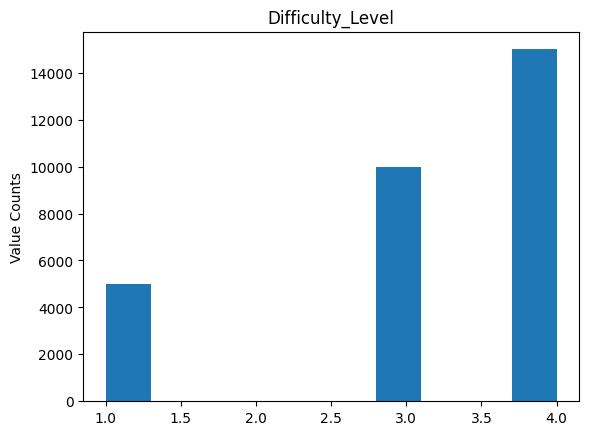

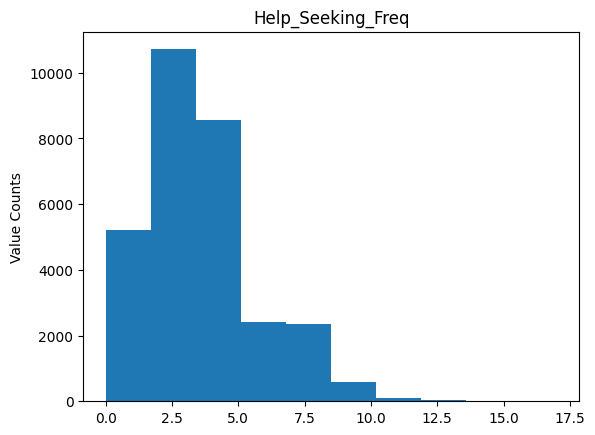

In [19]:
for feature in discrete_features:
    plt.hist(dataset[feature])
    plt.title(feature)
    plt.ylabel('Value Counts')
    plt.show()

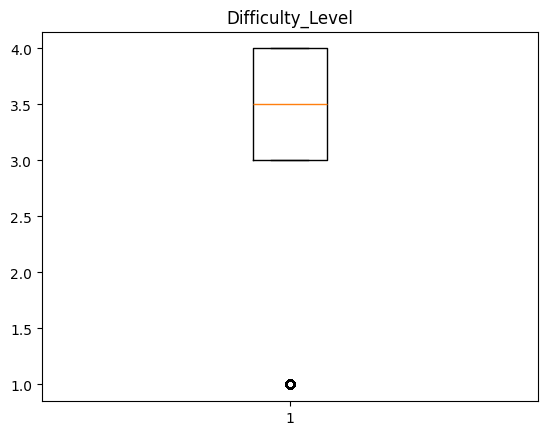

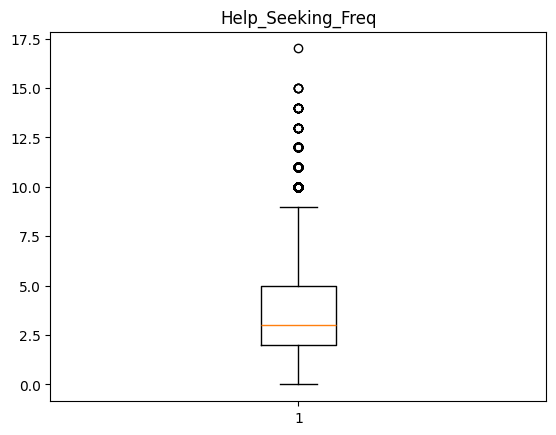

In [20]:
for feature in discrete_features:
    plt.boxplot(dataset[feature])
    plt.title(feature)
    plt.show()

### Continous Features

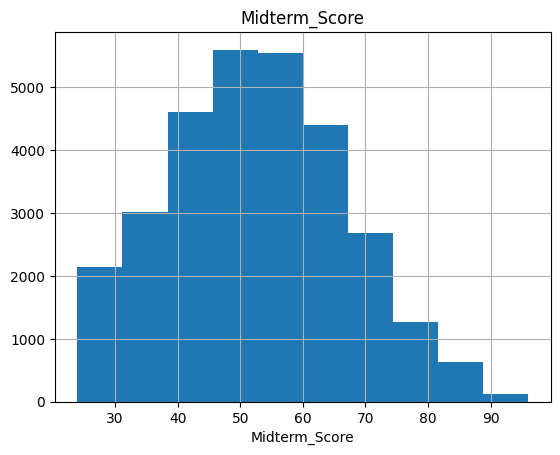

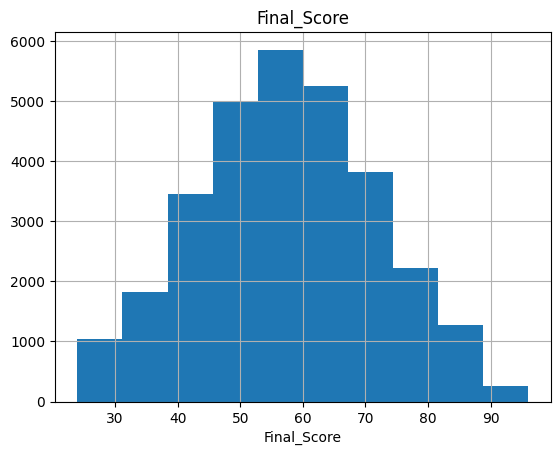

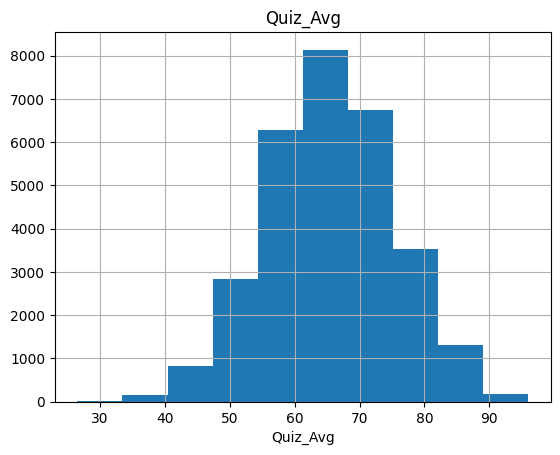

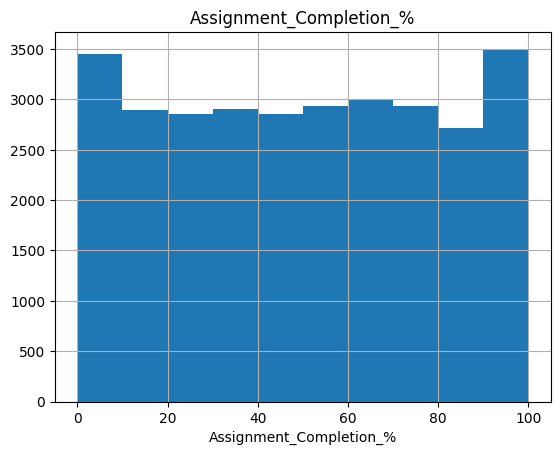

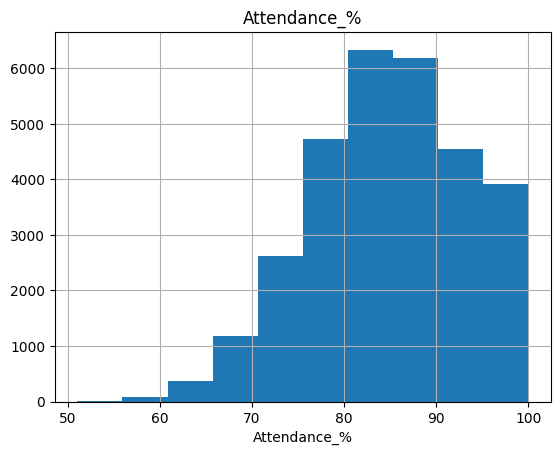

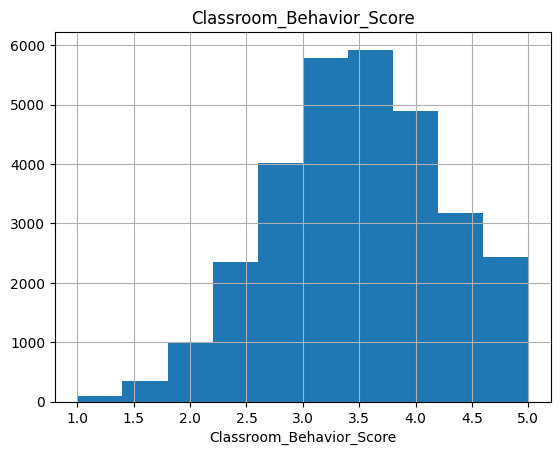

In [21]:
for feature in continous_features:
    dataset[feature].hist()
    plt.title(feature)
    plt.xlabel(feature)
    plt.show()

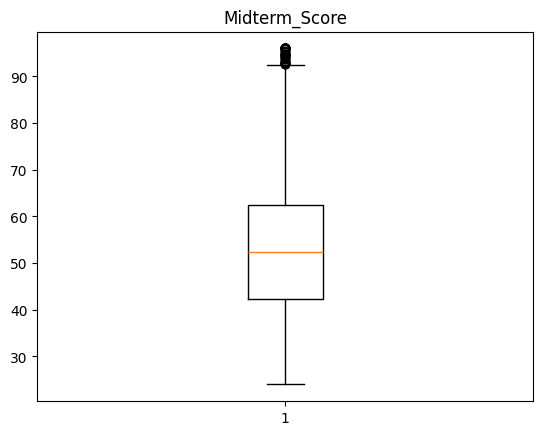

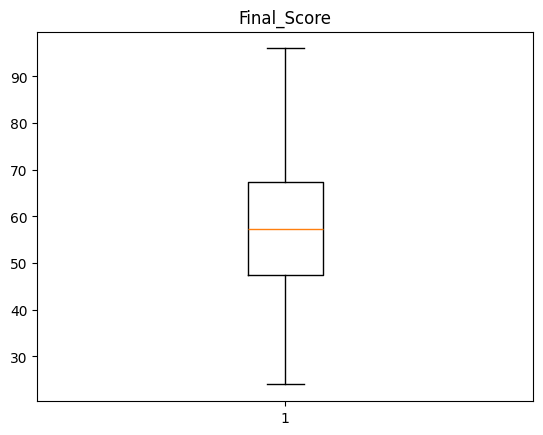

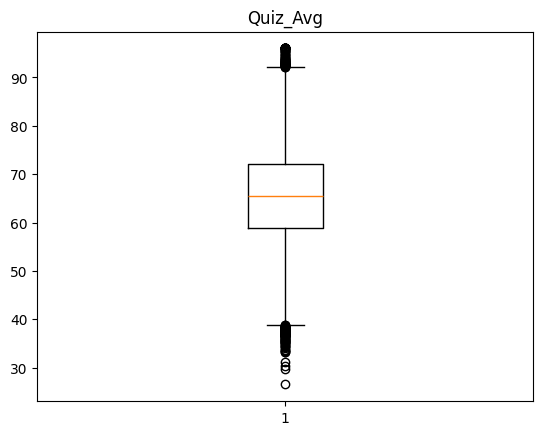

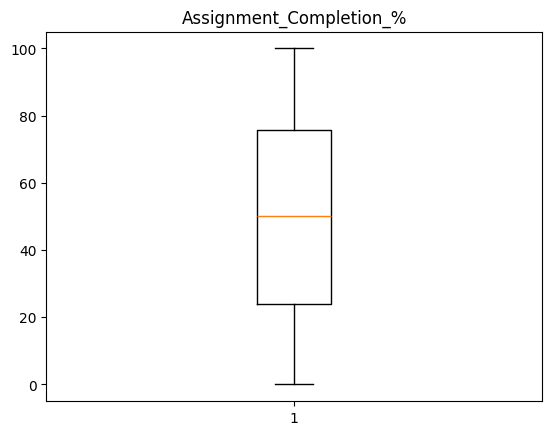

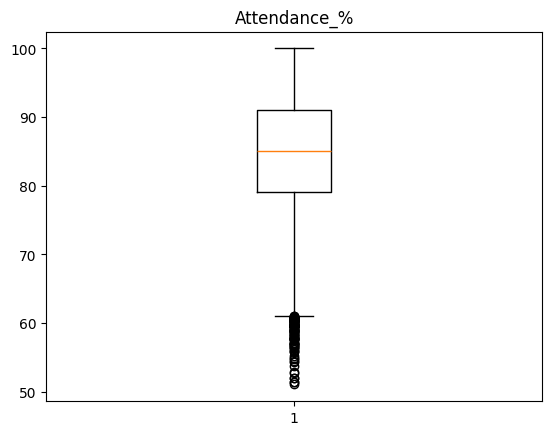

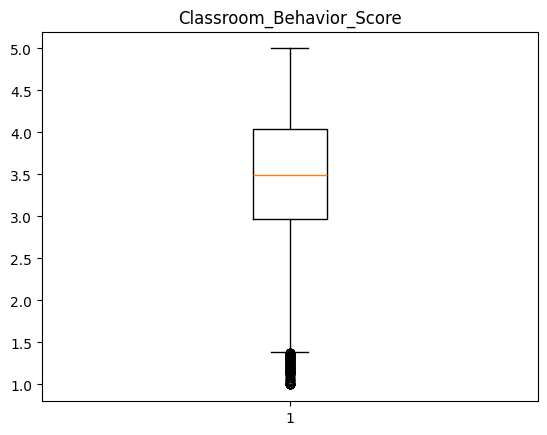

In [22]:
for feature in continous_features:
    plt.boxplot(dataset[feature])
    plt.title(feature)
    plt.show()

### Categorical Features

In [23]:
for feature in categorical_features:
    print(f"Feature : {feature}, Number of unique values : {dataset[feature].nunique()}")

Feature : Subject, Number of unique values : 6
Feature : Submission_Punctuality, Number of unique values : 2


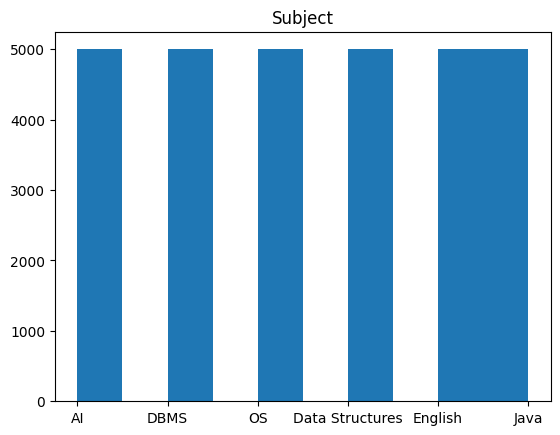

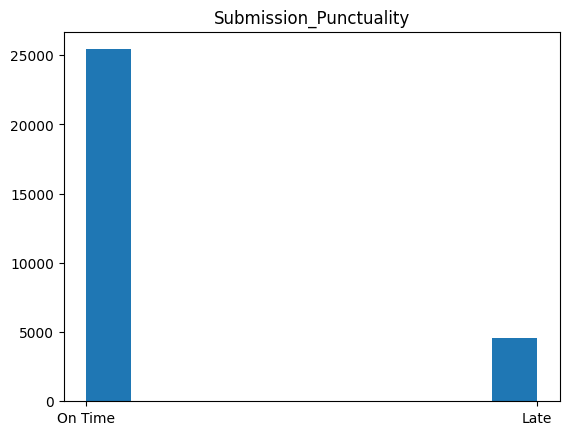

In [24]:
for feature in categorical_features:
    plt.hist(dataset[feature])
    plt.title(feature)
    plt.show()

In [25]:
dataset[numerical_features + ['Performance']].corr()['Performance']

Difficulty_Level           -0.113468
Midterm_Score               0.520321
Final_Score                 0.522054
Quiz_Avg                    0.418141
Assignment_Completion_%     0.483919
Attendance_%                0.253306
Help_Seeking_Freq          -0.267395
Classroom_Behavior_Score    0.350281
Performance                 1.000000
Name: Performance, dtype: float64

In [26]:
dataset.head()

,Student_ID,Subject,Difficulty_Level,Midterm_Score,Final_Score,Quiz_Avg,Assignment_Completion_%,Attendance_%,Help_Seeking_Freq,Classroom_Behavior_Score,Submission_Punctuality,Performance
0,1,AI,4,49.729545,52.182194,64.336185,64.370788,93.816161,4,2.775840,On Time,3
1,2,AI,4,43.083216,49.562362,62.047431,23.572177,86.346815,4,3.918936,On Time,0
2,3,AI,4,37.520454,54.503075,66.752802,27.787054,91.032778,5,4.983896,On Time,0
3,4,AI,4,60.929397,70.334479,78.190041,93.944225,93.587055,5,3.612891,On Time,3
4,5,AI,4,53.986757,63.630252,55.851495,6.900314,81.546249,1,3.261090,On Time,3


# Data Engineering

In [27]:
features_to_drop = ['Student_ID']
cleaned_data = dataset.drop(features_to_drop, axis=1)

70% ==> Training data, 15% ==> Validation data, 15% ==> Test data

In [28]:
X, y = cleaned_data.drop(['Performance'], axis=1), cleaned_data['Performance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [29]:
numerical_pipeline = Pipeline([
    ('clipper', outlier_clipper(cols=continous_features)),
    ('Scaler', RobustScaler())
])

In [30]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('target_enc', TargetEncoder(), ['Subject', 'Submission_Punctuality'])
])

In [31]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clipper',
                                                  outlier_clipper(cols=['Midterm_Score',
                                                                        'Final_Score',
                                                                        'Quiz_Avg',
                                                                        'Assignment_Completion_%',
                                                                        'Attendance_%',
                                                                        'Classroom_Behavior_Score'])),
                                                 ('Scaler', RobustScaler())]),
                                 ['Difficulty_Level', 'Midterm_Score',
                                  'Final_Score', 'Quiz_Avg',
                                  'Assignment_Completion_%', 'Attendance_%',
                                  'Help_Seeking_Freq',
                                  'Classroom_Behavior_Score']),
                                ('target_enc', TargetEncoder(),
                                 ['Subject', 'Submission_Punctuality'])])

In [34]:
joblib.dump(preprocessor, './models/preprocessor.pkl')

['./models/preprocessor.pkl']

In [35]:
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Model Building

In [36]:
def build_model():
    model = Sequential()
    model.add(Dense(121, activation='relu', input_shape=(X_train_processed.shape[1],)))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    return model
model = build_model()

c:\Users\Nikhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=20, batch_size=32)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9925 - loss: 0.0217 - val_accuracy: 0.9796 - val_loss: 0.0565
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9916 - loss: 0.0195 - val_accuracy: 0.9876 - val_loss: 0.0303
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9929 - loss: 0.0195 - val_accuracy: 0.9876 - val_loss: 0.0334
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9929 - loss: 0.0184 - val_accuracy: 0.9873 - val_loss: 0.0308
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9920 - loss: 0.0201 - val_accuracy: 0.9902 - val_loss: 0.0240
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9924 - loss: 0.0187 - val_accuracy: 0.9884 - val_loss: 0.0280
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9924 - loss: 0.0170 - val_accuracy: 0.9873 - val_loss: 0.0323
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9908 - loss: 0.0222 - val_accuracy: 0.

In [46]:
y_pred_prob = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([3, 3, 0, ..., 3, 3, 3])

In [47]:
model.save('./models/performance_pred_model.keras')

0 => Average, 1 => Excellent, 2 => Fail, 3 => Good

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1739
           1       0.95      0.93      0.94       232
           2       0.95      0.88      0.91        42
           3       0.99      0.99      0.99      2487

    accuracy                           0.99      4500
   macro avg       0.97      0.95      0.96      4500
weighted avg       0.99      0.99      0.99      4500



In [49]:
def predict(student_data, model):
    sample_input_processed = preprocessor.transform(student_data)
    prediction = model.predict(sample_input_processed)
    idx = np.argmax(prediction)
    result = result_dict[idx]
    print(f"Result : {result}")

In [51]:
sample_input = pd.DataFrame([{
    'Student_ID': 10001,
    'Subject': 'English',
    'Difficulty_Level': 1,
    'Midterm_Score': 60,
    'Final_Score': 60,
    'Quiz_Avg': 10,
    'Assignment_Completion_%': 76,
    'Attendance_%': 85,
    'Help_Seeking_Freq': 2,
    'Classroom_Behavior_Score': 7.3,
    'Submission_Punctuality': 'On Time'
}])

predict(sample_input, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Result : Average
